In [1]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
kenya_name = 'kenya'
rwanda_name = 'rwanda'
tanzania_name = 'tanzania'
uganda_name = 'uganda'

data_path = '../data/'
full = 'full'
append_in = '_'+full+'.csv'

#where to load from
kenya_load = os.path.join(data_path, full, kenya_name+append_in)
rwanda_load = os.path.join(data_path, full, rwanda_name+append_in)
tanzania_load = os.path.join(data_path, full, tanzania_name+append_in)
uganda_load = os.path.join(data_path, full, uganda_name+append_in)

In [3]:
#load data
kenya = pd.read_csv(kenya_load, index_col=0)
rwanda = pd.read_csv(rwanda_load, index_col=0)
tanzania = pd.read_csv(tanzania_load, index_col=0)
uganda = pd.read_csv(uganda_load, index_col=0)

#drop date column, we don't need this anymore
kenya.drop('Date-Monthly', axis=1, inplace=True)
rwanda.drop('Date-Monthly', axis=1, inplace=True)
tanzania.drop('Date-Monthly', axis=1, inplace=True)
uganda.drop('Date-Monthly', axis=1, inplace=True)

In [5]:
#i shortened some column names to make the feature importances plots easier to read
new_columns = ['precip', 'mintemp', 'maxtemp', 'DAP', 'Urea', 'Rural population',
       'Total Population - Both sexes', 'Total Population - Female',
       'Total Population - Male', 'Urban population',
       'Average dietary energy supply adequacy',
       'Political stability, absence of violence/terrorism index',
       'Agricultural land (1000 ha)', 'Arable land (1000 ha)',
       'Country area (1000 ha)', 'Cropland (1000 ha)', 'Forest land (1000 ha)',
       'Land area (1000 ha)', 'Land under permanent crops (1000 ha)',
       'Other naturally regenerated forest (1000 ha)',
       'Planted Forest (1000 ha)', 'Primary Forest (1000 ha)', 'price']

kenya.columns = new_columns
rwanda.columns = new_columns
tanzania.columns = new_columns
uganda.columns = new_columns

In [6]:
kenya.head()

,precip,mintemp,maxtemp,DAP,Urea,Rural population,Total Population - Both sexes,Total Population - Female,Total Population - Male,Urban population,...,Arable land (1000 ha),Country area (1000 ha),Cropland (1000 ha),Forest land (1000 ha),Land area (1000 ha),Land under permanent crops (1000 ha),Other naturally regenerated forest (1000 ha),Planted Forest (1000 ha),Primary Forest (1000 ha),price
0,4.460338,10.782270,27.047728,0.719813,0.583126,31314.145917,41560.307667,20926.222417,20634.092417,9572.27775,...,5500.0,58037.0,6020.0,4230.0,56914.0,520.0,4037.0,193.0,0.0,0.68
1,7.107909,10.659104,26.831646,0.719813,0.583126,31372.013333,41654.381333,20973.346333,20681.042333,9607.15600,...,5500.0,58037.0,6020.0,4230.0,56914.0,520.0,4037.0,193.0,0.0,0.64
2,11.365962,11.953104,27.468187,0.719813,0.583126,31429.880750,41748.455000,21020.470250,20727.992250,9642.03425,...,5500.0,58037.0,6020.0,4230.0,56914.0,520.0,4037.0,193.0,0.0,0.63
3,12.749496,13.551364,25.737667,0.737450,0.590842,31487.748167,41842.528667,21067.594167,20774.942167,9676.91250,...,5500.0,58037.0,6020.0,4230.0,56914.0,520.0,4037.0,193.0,0.0,0.64
4,10.510549,12.708521,25.077250,0.726427,0.571000,31545.615583,41936.602333,21114.718083,20821.892083,9711.79075,...,5500.0,58037.0,6020.0,4230.0,56914.0,520.0,4037.0,193.0,0.0,0.65


In [7]:
rwanda.head()

,precip,mintemp,maxtemp,DAP,Urea,Rural population,Total Population - Both sexes,Total Population - Female,Total Population - Male,Urban population,...,Arable land (1000 ha),Country area (1000 ha),Cropland (1000 ha),Forest land (1000 ha),Land area (1000 ha),Land under permanent crops (1000 ha),Other naturally regenerated forest (1000 ha),Planted Forest (1000 ha),Primary Forest (1000 ha),price
0,13.941298,13.327754,24.736055,0.565489,0.488326,8418.583167,9932.434667,5064.679833,4867.754833,1716.0105,...,1123.92,2634.0,1373.92,446.0,2467.0,250.0,55.0,384.0,7.0,0.42
1,31.847662,13.014627,24.108702,0.565489,0.488326,8437.195333,9953.815333,5075.435667,4878.379667,1719.8480,...,1123.92,2634.0,1373.92,446.0,2467.0,250.0,55.0,384.0,7.0,0.42
2,15.493356,14.120647,24.633526,0.565489,0.488326,8455.807500,9975.196000,5086.191500,4889.004500,1723.6855,...,1123.92,2634.0,1373.92,446.0,2467.0,250.0,55.0,384.0,7.0,0.42
3,18.309883,13.764366,24.545443,0.565489,0.488326,8474.419667,9996.576667,5096.947333,4899.629333,1727.5230,...,1123.92,2634.0,1373.92,446.0,2467.0,250.0,55.0,384.0,7.0,0.37
4,15.413672,13.781482,23.507832,0.565489,0.488326,8493.031833,10017.957333,5107.703167,4910.254167,1731.3605,...,1123.92,2634.0,1373.92,446.0,2467.0,250.0,55.0,384.0,7.0,0.44


Below, I am going to write a method that inputs a pandas DataFrame and performs a cross-validated random search for the best hyperparameters.  If you are interested in the differences between grid and random search, I found this [stackexchange](https://stats.stackexchange.com/questions/160479/practical-hyperparameter-optimization-random-vs-grid-search) post helpful.

I will be comparing two different models, RandomForest and XGBoost for regression. There are two main reasons we are using tree-based models in this project. 
- We want to be able to get out feature importances, since that is the main objective of this project: making crop prices interpretable.
- Tree-based models perform well when you have more columns (features) than rows (observations). That is definitely the case for this analysis, where the time period is short and at relatively course resolution, but there are a lot of variables that we want to look at.

First, though, we need to decide on a metric to use. Because we are trying to fit data where the target variable is price (on a continuous scale), we need to use some sort of squared error like mean squared error (MSE). Let's see what our options are in scikit-learn.

In [8]:
error_metrics = [metric for metric in sklearn.metrics.SCORERS.keys() if 'error' in metric]
error_metrics

['max_error',
 'neg_median_absolute_error',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_root_mean_squared_error']

Thanks to the following two blog posts for helping design the method below:
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

In [9]:
def randomsearch_cv(df):
    """
    
    Parameters:
      df: a DataFrame where the last column is the target variable
      
    Returns:
      forest_model: A RandomizedSearchCV object containing RandomForestRegressor
                    models and parameters after cross-validation
      xgboost_model: A RandomizedSearchCV object containing XGBoostRegressor
                    models and parameters after cross-validation 
    """
     #this is true for every dataset, price is the last column
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    
    #instantiate models here
    forest = RandomForestRegressor()
    xgboost = xgb.XGBRegressor()

    #define parameters dictionaries here
    rf_params = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
                 'max_depth': [1, 2, 4, 6, 8, 10, 20, 30, None],  #higher values often lead to overfitting
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [2, 5, 10],
                }
    
    xgb_params = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
                  'max_depth': [1, 2, 4, 6, 8, 10, 20, 30, None],
                  'colsample_bytree': np.linspace(0, 0.8, 9),
                  'learning_rate': np.linspace(0, 0.8, 9),
                  'alpha': [1e-5, 1e-2, 0.1, 1, 2, 4, 6, 8, 100],
                  'subsample': np.linspace(0, 0.8, 9)}
    
    #create our random search cv objects
    forest_search = RandomizedSearchCV(estimator=forest,
                            param_distributions=rf_params,
                            n_iter=10,         #number of parameter settings sampled
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1,         #use all processors available
                            cv=5,
                            verbose=2,         #print results during tuning
                            random_state=42
    )
    
    xgboost_search = RandomizedSearchCV(estimator=xgboost,
                            param_distributions=xgb_params,
                            n_iter=10,         #number of parameter settings sampled
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1,         #use all processors available
                            cv=5,
                            verbose=2,         #print results during tuning
                            random_state=42
    )
    
    #now fit the models and return them
    forest_model = forest_search.fit(X, y)
    xgboost_model = xgboost_search.fit(X, y)
    
    return forest_model, xgboost_model

Below, we can get the fitted models back for each country.

In [10]:
kenya_rf, kenya_xgb = randomsearch_cv(kenya)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


In [11]:
rwanda_rf, rwanda_xgb = randomsearch_cv(rwanda)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


In [12]:
tanzania_rf, tanzania_xgb = randomsearch_cv(tanzania)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [13]:
uganda_rf, uganda_xgb = randomsearch_cv(uganda)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    0.1s remaining:    0.0s


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


Let's see what our best estimator parameters looked like for Kenya.

In [19]:
print('Best RandomForest model for Kenya:')
print(kenya_rf.best_params_, '\n')

print('Best XGBoost model for Kenya:')
print(kenya_xgb.best_params_)

Best RandomForest model for Kenya:
{'n_estimators': 32, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 6} 

Best XGBoost model for Kenya:
{'subsample': 0.4, 'n_estimators': 32, 'max_depth': 4, 'learning_rate': 0.30000000000000004, 'colsample_bytree': 0.8, 'alpha': 1e-05}


In [50]:
def plot_importances(df, rf, xgb):
    """
    Input a dataframe as well as trained RandomForest and XGBoost
    models, plot feature importances.
    
    """
    columns = df.columns[:-1] #all columns except the target column
    importances_rf = rf.best_estimator_.feature_importances_
    importances_xgb = xgb.best_estimator_.feature_importances_
    
    #take the top ten feature importances
    idx_rf = np.argsort(importances_rf)
    #idx_rf = np.argsort(importances_rf)[-10:]
    #idx_xgb = np.argsort(importances_xgb)[-10:]
    idx_xgb = np.argsort(importances_xgb)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    #random forest and xgboost feature importances on the same plot
    ax.set_title('Feature Importances')
    ax.barh(range(len(idx_rf)), importances_rf[idx_rf], color='tab:blue', align='center', alpha=0.5, label='RF')
    ax.barh(range(len(idx_rf)), importances_xgb[idx_rf], color='tab:orange', align='center', alpha=0.5, label='XGB')
    ax.set_yticks(range(len(idx_rf)))
    ax.set_yticklabels([columns[i] for i in idx_rf], fontsize=10)
    ax.set_xlabel('Relative Importance')

    ax.legend()
    plt.show()

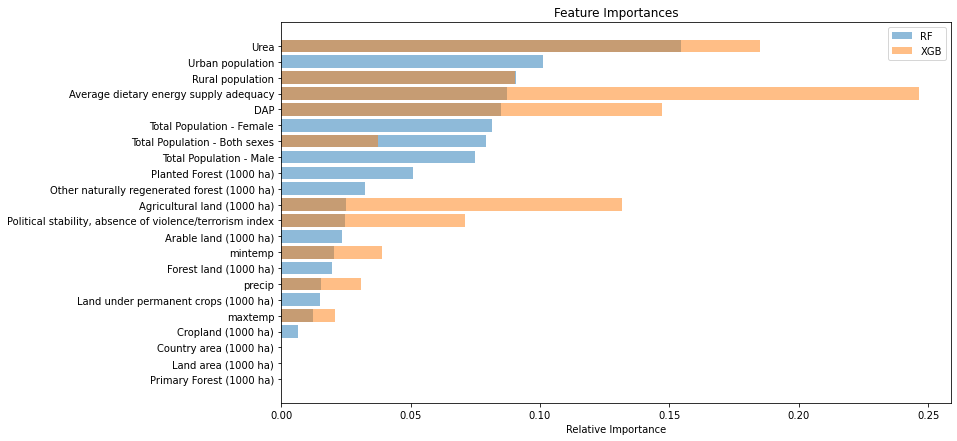

In [51]:
plot_importances(kenya, kenya_rf, kenya_xgb)

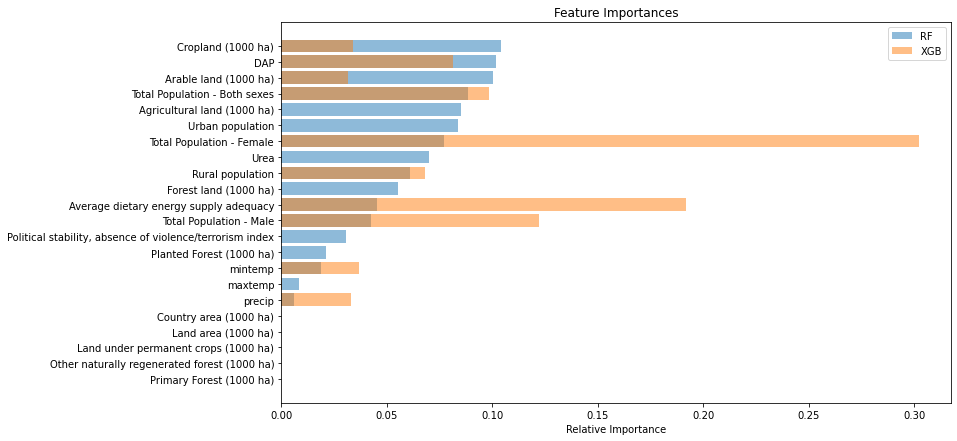

In [52]:
plot_importances(rwanda, rwanda_rf, rwanda_xgb)

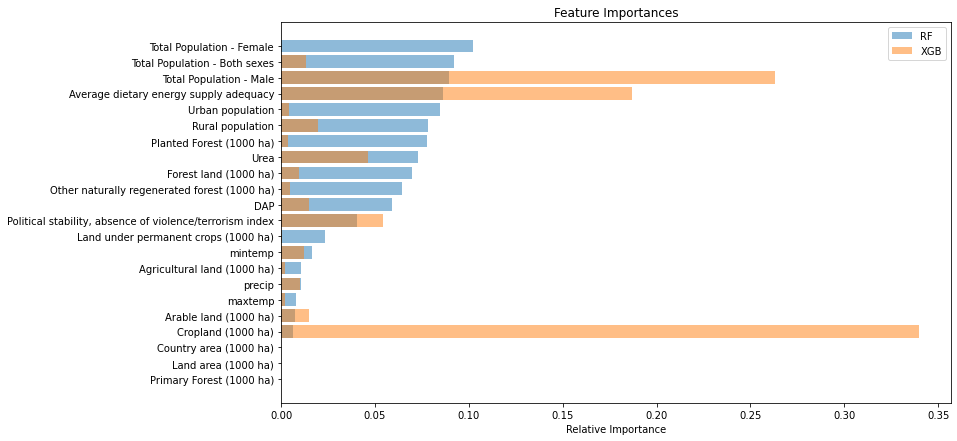

In [53]:
plot_importances(tanzania, tanzania_rf, tanzania_xgb)

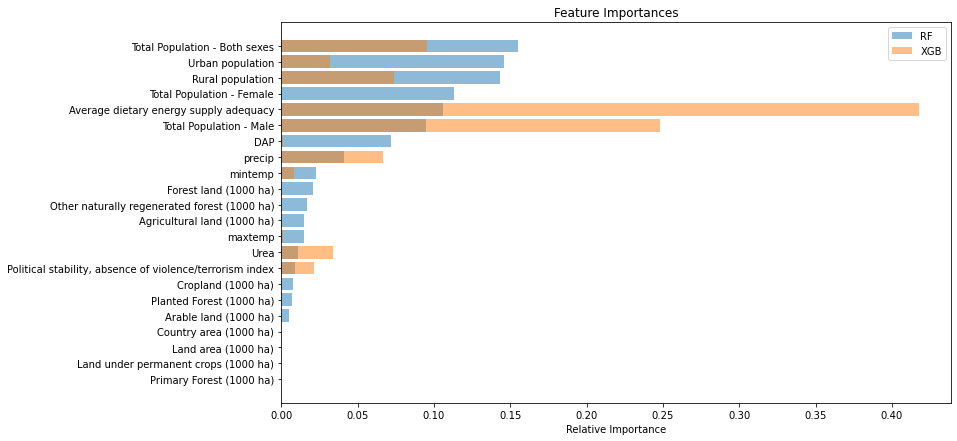

In [54]:
plot_importances(uganda, uganda_rf, uganda_xgb)

So so far:
- `Kenya`: the price of Urea, political instability, and the rural population factor in prominently to price.
- `Rwanda`: population mostly determines price, but it is also affected by Urea price and the minimum temperatures.
- `Tanzania`: precipitation, rural population, and DAP cost seem to be the biggest price influencers.
- `Uganda`: seems much more influenced by total population than anything else, but also is sensitive to precipitation.

The Rwanda data seems particularly affected by the `alpha` regularization parameter. I could try different regularization parameters, but and `alpha` value >= 5 makes it so that no score is reported for Rwanda.

Where to go from here:
- Try to do grid search instead of just cross-validation. Then isolate a best model and use that to plot the feature importances.
- See how a RandomForest model's feature importances compare. You could make the method that you already have more general to accept either a XGBoost or RandomForest model.